# Importing Libraries

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

Use cuda if available

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [80]:
train = "/kaggle/input/chest-xray-pneumonia/"
val = "/kaggle/input/chest-xray-pneumonia/"
test = "/kaggle/input/chest-xray-pneumonia/"

In [81]:
class ChestXRayDataset(Dataset):
    """
    Custom Dataset for Chest X-Ray images with proper preprocessing
    Handles PNG/DICOM images with normalization and augmentation
    """
    def __init__(self, image_paths, labels, transform=None, is_train=True):
        """
        Args:
            image_paths: List of image file paths
            labels: List of labels (0: Normal, 1: Pneumonia)
            transform: torchvision transforms to apply
            is_train: Boolean indicating training mode for augmentation
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            label = self.labels[idx]
            
            return image, label
        
        except Exception as e:
            print(f"⚠ Error loading image {img_path}: {e}")
            # Return a random valid sample instead
            random_idx = np.random.randint(0, len(self.image_paths))
            return self.__getitem__(random_idx)

In [82]:
def get_data_transforms(img_size=224):
    """
    Define data augmentation and normalization transforms
    
    Args:
        img_size: Target image size (default 224 for standard CNNs)
    
    Returns:
        Dictionary of transforms for train, validation, and test
    """
    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/Test transforms without augmentation
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    return {
        'train': train_transform, 
        'val': val_test_transform,
        'test': val_test_transform
    }



In [83]:
def load_dataset_paths(root_dir, split='train'):
    """
    Load image paths and labels from directory structure
    
    Args:
        root_dir: Root directory containing chest_xray folder
        split: 'train', 'val', or 'test'
    
    Returns:
        image_paths: List of full image paths
        labels: List of corresponding labels (0: Normal, 1: Pneumonia)
    """
    # Correct directory structure
    split_dir = os.path.join(root_dir, 'chest_xray', split)
    normal_dir = os.path.join(split_dir, 'NORMAL')
    pneumonia_dir = os.path.join(split_dir, 'PNEUMONIA')
    
    image_paths = []
    labels = []
    
    # Load Normal images (label 0)
    if os.path.exists(normal_dir):
        for img_name in os.listdir(normal_dir):
            # Skip macOS system files
            if img_name.startswith('._') or img_name == '.DS_Store':
                continue
            
            img_path = os.path.join(normal_dir, img_name)
            
            # Only add valid image files
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(0)  # 0 for Normal
    else:
        print(f"⚠ Warning: {normal_dir} does not exist!")
    
    # Load Pneumonia images (label 1)
    if os.path.exists(pneumonia_dir):
        for img_name in os.listdir(pneumonia_dir):
            # Skip macOS system files
            if img_name.startswith('._') or img_name == '.DS_Store':
                continue
            
            img_path = os.path.join(pneumonia_dir, img_name)
            
            # Only add valid image files
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(1)  # 1 for Pneumonia
    else:
        print(f"⚠ Warning: {pneumonia_dir} does not exist!")
    
    return image_paths, labels


In [84]:
# Configuration
ROOT_DIR = '/kaggle/input/chest-xray-pneumonia/'
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 0  # Set to 0 to avoid multiprocessing issues

print("="*60)
print("LOADING DATASET")
print("="*60)

# Get transforms
transforms_dict = get_data_transforms(img_size=IMG_SIZE)

# Load training data
print("\n📂 Loading TRAIN set...")
train_paths, train_labels = load_dataset_paths(ROOT_DIR, split='train')
print(f"   ✓ Loaded {len(train_paths)} training images")
print(f"   - Normal: {train_labels.count(0)}")
print(f"   - Pneumonia: {train_labels.count(1)}")

# Load validation data
print("\n📂 Loading VALIDATION set...")
val_paths, val_labels = load_dataset_paths(ROOT_DIR, split='val')
print(f"   ✓ Loaded {len(val_paths)} validation images")
print(f"   - Normal: {val_labels.count(0)}")
print(f"   - Pneumonia: {val_labels.count(1)}")

# Load test data
print("\n📂 Loading TEST set...")
test_paths, test_labels = load_dataset_paths(ROOT_DIR, split='test')
print(f"   ✓ Loaded {len(test_paths)} test images")
print(f"   - Normal: {test_labels.count(0)}")
print(f"   - Pneumonia: {test_labels.count(1)}")

# Create datasets
print("\n🔧 Creating PyTorch Datasets...")
train_dataset = ChestXRayDataset(
    train_paths, 
    train_labels, 
    transform=transforms_dict['train'],
    is_train=True
)

val_dataset = ChestXRayDataset(
    val_paths, 
    val_labels, 
    transform=transforms_dict['val'],
    is_train=False
)

test_dataset = ChestXRayDataset(
    test_paths, 
    test_labels, 
    transform=transforms_dict['test'],
    is_train=False
)

print(f"   ✓ Train dataset: {len(train_dataset)} samples")
print(f"   ✓ Val dataset: {len(val_dataset)} samples")
print(f"   ✓ Test dataset: {len(test_dataset)} samples")

# Create dataloaders
print("\n🔄 Creating DataLoaders...")
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  # Shuffle training data
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Don't shuffle validation
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Don't shuffle test
    num_workers=NUM_WORKERS, 
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"   ✓ Train loader: {len(train_loader)} batches")
print(f"   ✓ Val loader: {len(val_loader)} batches")
print(f"   ✓ Test loader: {len(test_loader)} batches")

# Class distribution analysis
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

total_train = len(train_labels)
train_normal = train_labels.count(0)
train_pneumonia = train_labels.count(1)

print(f"\n📊 Training Set:")
print(f"   Total: {total_train}")
print(f"   Normal: {train_normal} ({100*train_normal/total_train:.1f}%)")
print(f"   Pneumonia: {train_pneumonia} ({100*train_pneumonia/total_train:.1f}%)")
print(f"   Class Imbalance Ratio: {train_pneumonia/train_normal:.2f}:1")

total_val = len(val_labels)
val_normal = val_labels.count(0)
val_pneumonia = val_labels.count(1)

print(f"\n📊 Validation Set:")
print(f"   Total: {total_val}")
print(f"   Normal: {val_normal} ({100*val_normal/total_val:.1f}%)")
print(f"   Pneumonia: {val_pneumonia} ({100*val_pneumonia/total_val:.1f}%)")

total_test = len(test_labels)
test_normal = test_labels.count(0)
test_pneumonia = test_labels.count(1)

print(f"\n📊 Test Set:")
print(f"   Total: {total_test}")
print(f"   Normal: {test_normal} ({100*test_normal/total_test:.1f}%)")
print(f"   Pneumonia: {test_pneumonia} ({100*test_pneumonia/total_test:.1f}%)")

# Calculate class weights for handling imbalance
print("\n" + "="*60)
print("CLASS WEIGHTS FOR LOSS FUNCTION")
print("="*60)

# Inverse frequency weighting
weight_normal = total_train / (2 * train_normal)
weight_pneumonia = total_train / (2 * train_pneumonia)

print(f"\n⚖️ Recommended class weights:")
print(f"   Normal: {weight_normal:.4f}")
print(f"   Pneumonia: {weight_pneumonia:.4f}")
print(f"\n💡 Use these weights in CrossEntropyLoss:")
print(f"   class_weights = torch.tensor([{weight_normal:.4f}, {weight_pneumonia:.4f}])")
print(f"   criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))")

print("\n" + "="*60)
print("✅ DATA LOADING COMPLETE")
print("="*60)

# Test loading a batch
print("\n🧪 Testing batch loading...")
try:
    sample_batch, sample_labels = next(iter(train_loader))
    print(f"   ✓ Batch shape: {sample_batch.shape}")
    print(f"   ✓ Label shape: {sample_labels.shape}")
    print(f"   ✓ Data type: {sample_batch.dtype}")
    print(f"   ✓ Value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
except Exception as e:
    print(f"   ❌ Error loading batch: {e}")


LOADING DATASET

📂 Loading TRAIN set...
   ✓ Loaded 5216 training images
   - Normal: 1341
   - Pneumonia: 3875

📂 Loading VALIDATION set...
   ✓ Loaded 16 validation images
   - Normal: 8
   - Pneumonia: 8

📂 Loading TEST set...
   ✓ Loaded 624 test images
   - Normal: 234
   - Pneumonia: 390

🔧 Creating PyTorch Datasets...
   ✓ Train dataset: 5216 samples
   ✓ Val dataset: 16 samples
   ✓ Test dataset: 624 samples

🔄 Creating DataLoaders...
   ✓ Train loader: 163 batches
   ✓ Val loader: 1 batches
   ✓ Test loader: 20 batches

DATASET STATISTICS

📊 Training Set:
   Total: 5216
   Normal: 1341 (25.7%)
   Pneumonia: 3875 (74.3%)
   Class Imbalance Ratio: 2.89:1

📊 Validation Set:
   Total: 16
   Normal: 8 (50.0%)
   Pneumonia: 8 (50.0%)

📊 Test Set:
   Total: 624
   Normal: 234 (37.5%)
   Pneumonia: 390 (62.5%)

CLASS WEIGHTS FOR LOSS FUNCTION

⚖️ Recommended class weights:
   Normal: 1.9448
   Pneumonia: 0.6730

💡 Use these weights in CrossEntropyLoss:
   class_weights = torch.tensor(

In [85]:
from torchvision import models

In [86]:
def get_resnet50_model(num_classes=2, freeze_features=True):
    """
    Returns modified ResNet50 model for binary classification.
    If freeze_features=True, only the final layer's parameters are trainable.
    """
    # Load pretrained ResNet50
    model = models.resnet50(pretrained=True)
    
    # Freeze feature layers if specified
    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace final fully connected layer for binary classification
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model

In [87]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
IMG_SIZE = 224
DROPOUT_RATE = 0.5
NUM_CLASSES = 2

In [88]:
model = get_resnet50_model(num_classes=2, freeze_features=True)
model = model.to(device)

In [89]:
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


MODEL ARCHITECTURE
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

In [90]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Get probabilities and predictions
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect statistics
            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of pneumonia class
    
    epoch_loss = running_loss / len(all_labels)
    
    return epoch_loss, all_labels, all_preds, all_probs

In [91]:
def calculate_metrics(y_true, y_pred, y_probs):
    """
    Calculate comprehensive evaluation metrics
    
    Returns:
        Dictionary containing accuracy, AUC, sensitivity, specificity
    """
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # AUC
    auc = roc_auc_score(y_true, y_probs)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Sensitivity (Recall) - True Positive Rate
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Specificity - True Negative Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics = {
        'accuracy': accuracy,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'confusion_matrix': cm
    }
    
    return metrics

In [92]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Adam optimizer - ONLY on trainable parameters (the new fc layer)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=LEARNING_RATE, 
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training loop
print("\n" + "="*50)
print("TRAINING ResNet50 with Transfer Learning")
print("="*50)

best_val_auc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 30)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                        optimizer, device)
    
    # Validate
    val_loss, val_labels, val_preds, val_probs = validate(
        model, val_loader, criterion, device
    )
    
    # Calculate metrics
    val_metrics = calculate_metrics(val_labels, val_preds, val_probs)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_metrics['accuracy'])
    
    # Print metrics
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_metrics["accuracy"]:.4f}')
    print(f'Val AUC: {val_metrics["auc"]:.4f}')
    print(f'Sensitivity: {val_metrics["sensitivity"]:.4f} | Specificity: {val_metrics["specificity"]:.4f}')
    
    # Save best model
    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': best_val_auc,
            'val_metrics': val_metrics
        }, 'best_resnet50_model.pth')
        print(f'✓ Saved best model (AUC: {best_val_auc:.4f})')


TRAINING ResNet50 with Transfer Learning

Epoch 1/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Train Loss: 0.2901 | Train Acc: 0.8694
Val Loss: 0.6409 | Val Acc: 0.6250
Val AUC: 1.0000
Sensitivity: 1.0000 | Specificity: 0.2500
✓ Saved best model (AUC: 1.0000)

Epoch 2/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Train Loss: 0.2093 | Train Acc: 0.9149
Val Loss: 0.3084 | Val Acc: 0.8125
Val AUC: 1.0000
Sensitivity: 1.0000 | Specificity: 0.6250

Epoch 3/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train Loss: 0.1908 | Train Acc: 0.9220
Val Loss: 0.5700 | Val Acc: 0.6875
Val AUC: 1.0000
Sensitivity: 1.0000 | Specificity: 0.3750

Epoch 4/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train Loss: 0.1713 | Train Acc: 0.9317
Val Loss: 0.5640 | Val Acc: 0.6875
Val AUC: 1.0000
Sensitivity: 1.0000 | Specificity: 0.3750

Epoch 5/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train Loss: 0.1614 | Train Acc: 0.9363
Val Loss: 0.2963 | Val Acc: 0.9375
Val AUC: 0.9688
Sensitivity: 0.8750 | Specificity: 1.0000

Epoch 6/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train Loss: 0.1760 | Train Acc: 0.9264
Val Loss: 0.6218 | Val Acc: 0.6875
Val AUC: 0.9531
Sensitivity: 1.0000 | Specificity: 0.3750

Epoch 7/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Train Loss: 0.1619 | Train Acc: 0.9312
Val Loss: 0.4732 | Val Acc: 0.7500
Val AUC: 0.9531
Sensitivity: 1.0000 | Specificity: 0.5000

Epoch 8/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train Loss: 0.1538 | Train Acc: 0.9390
Val Loss: 0.3376 | Val Acc: 0.8750
Val AUC: 0.9688
Sensitivity: 1.0000 | Specificity: 0.7500

Epoch 9/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train Loss: 0.1633 | Train Acc: 0.9365
Val Loss: 0.5247 | Val Acc: 0.7500
Val AUC: 0.9844
Sensitivity: 1.0000 | Specificity: 0.5000

Epoch 10/10
------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

Train Loss: 0.1524 | Train Acc: 0.9385
Val Loss: 0.4011 | Val Acc: 0.8125
Val AUC: 0.9688
Sensitivity: 1.0000 | Specificity: 0.6250


In [93]:
def plot_confusion_matrix(cm, class_names=['Normal', 'Pneumonia']):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()


def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.close()

In [94]:
# Plot training curves
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

In [95]:
# Final validation
_, val_labels, val_preds, val_probs = validate(model, val_loader, criterion, device)
final_metrics = calculate_metrics(val_labels, val_preds, val_probs)

print(f"\nAccuracy: {final_metrics['accuracy']:.4f}")
print(f"AUC: {final_metrics['auc']:.4f}")
print(f"Sensitivity (Recall): {final_metrics['sensitivity']:.4f}")
print(f"Specificity: {final_metrics['specificity']:.4f}")
print(f"\nConfusion Matrix:")
print(final_metrics['confusion_matrix'])

Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Accuracy: 0.8125
AUC: 0.9688
Sensitivity (Recall): 1.0000
Specificity: 0.6250

Confusion Matrix:
[[5 3]
 [0 8]]


In [96]:
# Plot confusion matrix
plot_confusion_matrix(final_metrics['confusion_matrix'])

In [97]:
import torch
import torch.nn.functional as F

def evaluate_model(model, test_loader, criterion, device):
    """
    Returns test loss and accuracy for your trained model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = running_loss / total
    test_accuracy = 100 * correct / total
    
    return test_loss, test_accuracy

# Example usage:
# criterion = torch.nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.3471
Test Accuracy: 87.82%


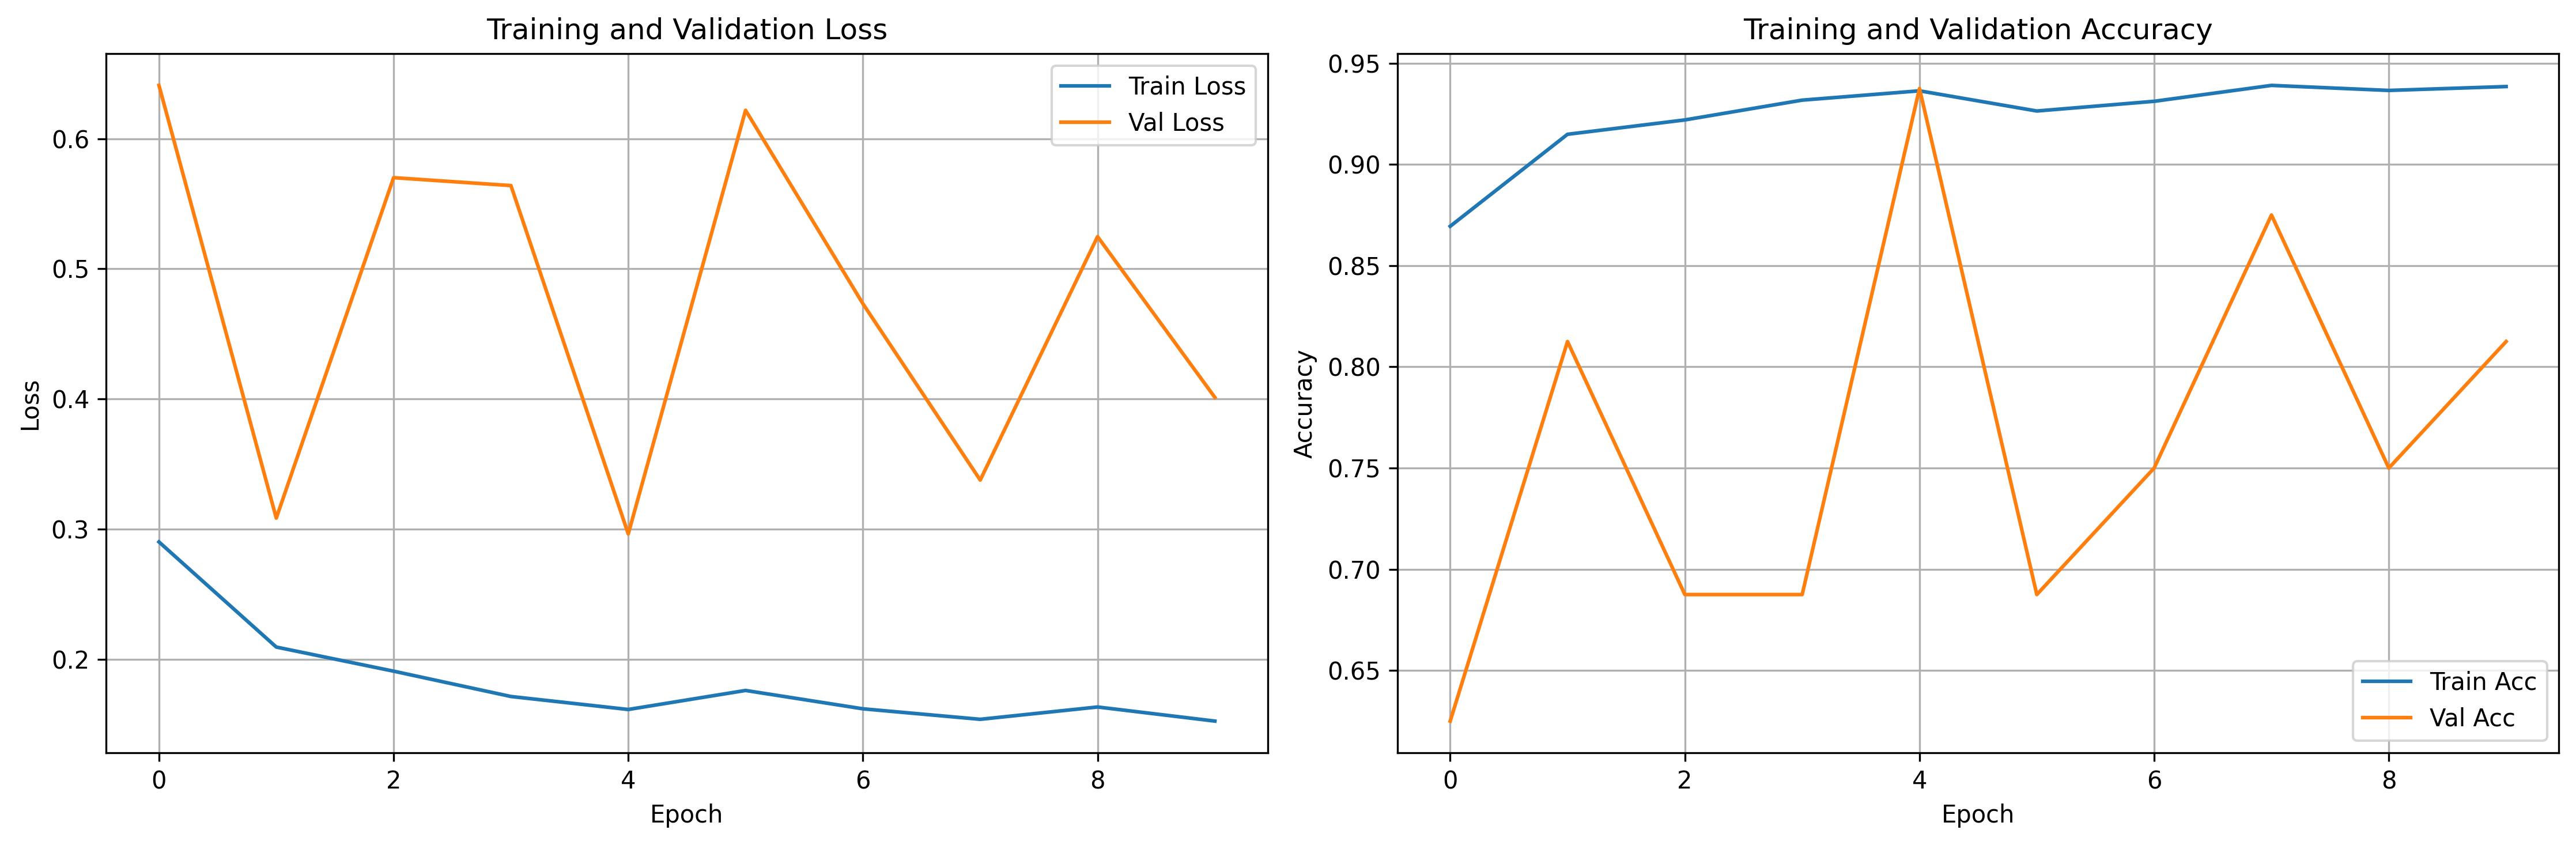

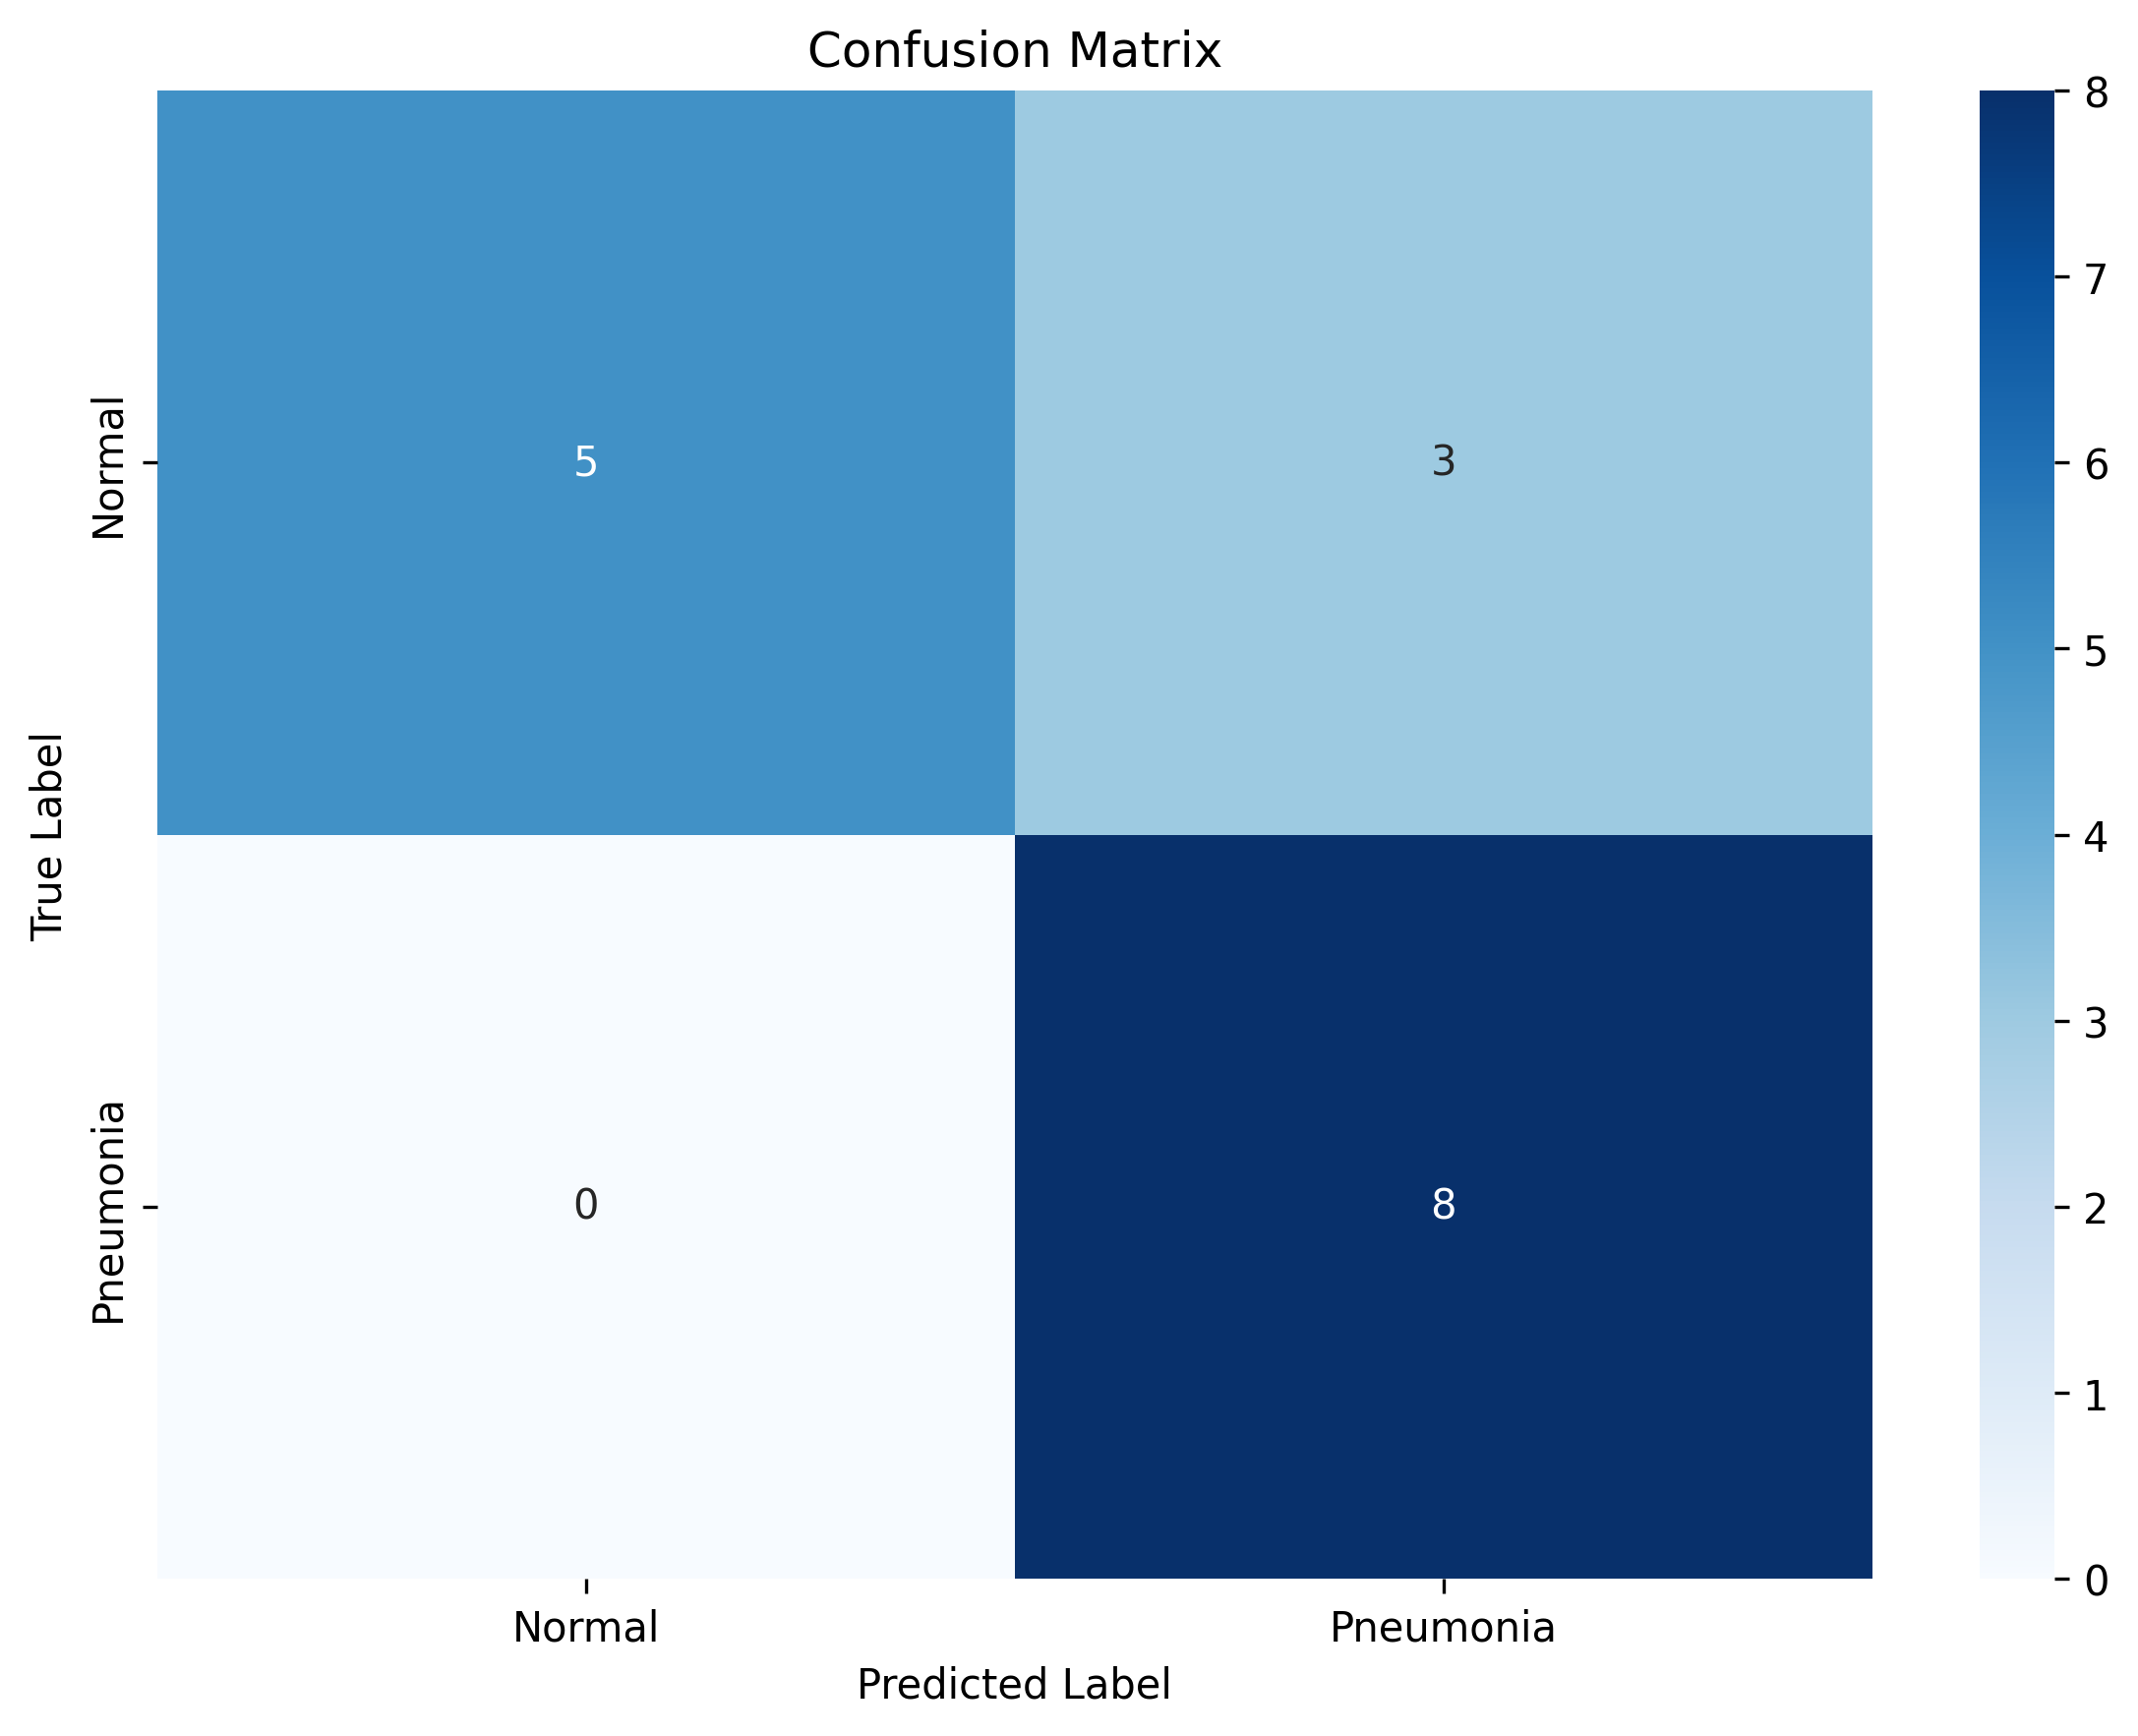

In [98]:
from IPython.display import Image, display

display(Image(filename='training_curves.png'))
display(Image(filename='confusion_matrix.png'))
